# QAOA Weighted Maxcut

MaxCut problem — given a graph, find a way to divide it into two groups, such that the edges going between the two groups have the biggest possible weight. <br>
The code below is the generalised solution for weighted maxcut by introducing minor changes in [the code for unweighted graph](https://lucaman99.github.io/new_blog/2020/mar16.html) by [Jack Ceroni](https://lucaman99.github.io/)

### Cost function

The MAXCUT objective is to minimize the cost function: $C \ = \ \displaystyle\sum_{a, \ b} \ \frac{1}{2} w_{ab} (c_a c_b \ - \ 1) \ \ \ \ \ (a, \ b) \ \in \ E$


### Constructing the Hamiltonian

The Hamiltonian can be constructed by mapping binary variables $c_i$ onto the eigenvalues of $Z$. The above minimization problem has the following Hamiltonian:

$\hat{H}_C \ = \ \displaystyle\sum_{a, \ b} \ \frac{1}{2} w_{ab} (Z_a \ \otimes \ Z_b \ - \ \mathbb{I}) \ \ \ \ \ (a, \ b) \ \in \ E$

### Choosing the Mixer
We choose our mixer:

$\hat{H}_M \ = \ \displaystyle\sum_{n} X_{n}$

Where n sums over all qubits. This does not commute with $\hat{H}_C$.

### Constructing QAOA circuit

The full QAOA circuit:

$|\psi{(\mathbb{\alpha},\mathbb{\gamma})}> =  e^{-i\alpha_p \hat{H}_M}e^{-i\gamma_p \hat{H}_C}\cdots e^{-i\alpha_1 \hat{H}_M}e^{-i\gamma_1 \hat{H}_C} H^{\otimes n} |0>$

Need to implement cost operator $e^{-i\gamma_p \hat{H}_C}$ and mixer operator $e^{-i\alpha_p \hat{H}_M}$

### Graph construction:
The Graph is constructed using the Python Library: networkx. A custom class called "Edge" is created to store start node, end node and weight of the edge.<br> 
A list called "set_edge" store all the edges of the Graph.<br>


{('0', '1'): Text(0.11231403455952077, 0.5395763515145473, '5'),
 ('0', '2'): Text(-0.07798366049905786, 0.5241019776386556, '1'),
 ('1', '2'): Text(-0.11345599610085805, 0.2652141349886634, '7'),
 ('1', '3'): Text(0.04234753243682461, -0.02410197763865543, '4'),
 ('2', '3'): Text(-0.147950162621754, -0.03957635151454704, '2'),
 ('3', '4'): Text(0.039562811020197486, -0.664446232070933, '3')}

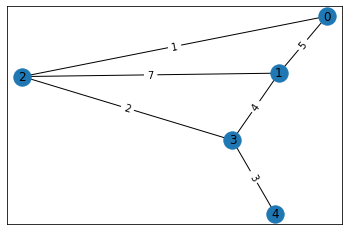

In [64]:
import networkx as nx
from matplotlib import pyplot as plt

class Graph:
    def __init__(self, edges_set):
        self.edges_set = edges_set
        self.node_set = []
        for i in edges_set:
            if (i.start_node not in self.node_set):
                self.node_set.append(i.start_node)
            if (i.end_node not in self.node_set):
                self.node_set.append(i.end_node)

class Edge:
    def __init__(self, start_node, end_node, edge_weight):
        self.start_node = start_node
        self.end_node = end_node
        self.edge_weight = edge_weight

set_edges = [Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7), Edge(1, 3, 4), Edge(2, 3, 2), Edge(3, 4, 3)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.edge_weight)


pos=nx.spring_layout(G) 
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

### Importing necessary libraries, specifying all of the initial parameters, and defining a function that gives us our initial state, which will just be an even superposition of all basis states.

In [65]:
import cirq
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize

# Defines the list of qubits

num = 5
depth = 4
rep = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]


# Defines the initialization

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

### Function for Cost and Mixer layers:
 cost operator $e^{-i\gamma_p \hat{H}_C}$ and mixer operator $e^{-i\alpha_p \hat{H}_M}$

In [66]:
# Defines the cost unitary

def cost_unitary(qubits, gamma):
    for i in set_edges:
        yield cirq.ZZPowGate(exponent=-1*gamma*i.edge_weight/math.pi).on(qubits[i.start_node], qubits[i.end_node])

# Defines the mixer unitary

def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        yield cirq.XPowGate(exponent=-1*alpha/math.pi).on(qubits[i])

### Function to create and execute the QAOA circuit:


In [67]:
# Executes the circuit

def create_circuit(params):

    gamma = [params[0], params[2], params[4], params[6]]
    alpha = [params[1], params[3], params[5], params[7]]

    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    circuit.append(cirq.measure(*qubits, key='x'))
    print(circuit)

    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    return new_res

### The cost function:
$C \ = \ \displaystyle\sum_{a, \ b} \ \frac{1}{2} w_{ab} (c_a c_b \ - \ 1) \ \ \ \ \ (a, \ b) \ \in \ E$<br>
Since the values that are outputted from the circuit are 0s and 1s, instead of the desired 1 and −1 values. Thus, in the place of $c_n$, we defined a function $f(x) \ = \ 1 \ - \ 2x$, which maps 0 to 1 and 1 to −1:

In [68]:
# Defines the cost function

def cost_function(params):

    av = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        for j in set_edges:
            total_cost += j.edge_weight*0.5*( ( (1 - 2*av[i][j.start_node]) * (1 - 2*av[i][j.end_node]) ) - 1)
    total_cost = float(total_cost)/rep

    print("Cost: "+str(total_cost))

    return total_cost

### Function for Optimization:
This function outputs the expected value of the cost function (calculate the average cost over 1000 repetitions of the algorithm). Finally, we can define a classical optimizer to tune the γ and α paramters until we arrive at a minimum expected value of the cost function. Along with the cost function, we write a bit of code that allows us to graph the results:

In [69]:
# Defines the optimization method
def optimize():
    init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
    out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})
    print(out)

    optimal_params = out['x']
    f = create_circuit(optimal_params)

    # Creates visualization of the optimal state

    nums = []
    freq = []

    for i in range(0, len(f)):
        number = 0
        for j in range(0, len(f[i])):
            number += 2**(len(f[i])-j-1)*f[i][j]
        if (number in nums):
            freq[nums.index(number)] = freq[nums.index(number)] + 1
        else:
            nums.append(number)
            freq.append(1)

    freq = [s/sum(freq) for s in freq]

    print(nums)
    print(freq)

    x = range(0, 2**num)
    y = []
    for i in range(0, len(x)):
        if (i in nums):
            y.append(freq[nums.index(i)])
        else:
            y.append(0)
    return [x,y]

In [70]:
def plot_bar_graph(x,y):
    plt.bar(x, y)
    plt.show()

## Results:

In [71]:
x, y = optimize()

(0, 0): ───H───ZZ─────────ZZ────────X^-0.446──────────────────────────ZZ──────────ZZ──────────X^0.08───────────────────────────ZZ────────────ZZ─────────X^-0.678───────────────────────────ZZ──────────ZZ──────────X^(2/15)─────────────────────────────────────────────────M('x')───
               │          │                                           │           │                                            │             │                                             │           │                                                                    │
(0, 1): ───H───ZZ^0.801───┼─────────ZZ──────────ZZ─────────X^-0.446───ZZ^-0.743───┼───────────ZZ─────────ZZ─────────X^0.08─────ZZ^(6/11)─────┼──────────ZZ──────────ZZ─────────X^-0.678────ZZ^0.424────┼───────────ZZ──────────ZZ─────────X^(2/15)──────────────────────────M────────
                          │         │           │                                 │           │          │                                   │          │           │         

(0, 0): ───H───ZZ─────────ZZ─────────X^-0.764───────────────────────────ZZ──────────ZZ──────────X^-0.239─────────────────────────ZZ────────────ZZ─────────X^-0.678───────────────────────────ZZ──────────ZZ──────────X^(2/15)─────────────────────────────────────────────────M('x')───
               │          │                                             │           │                                            │             │                                             │           │                                                                    │
(0, 1): ───H───ZZ^-0.79───┼──────────ZZ───────────ZZ─────────X^-0.764───ZZ^-0.743───┼───────────ZZ─────────ZZ─────────X^-0.239───ZZ^(6/11)─────┼──────────ZZ──────────ZZ─────────X^-0.678────ZZ^0.424────┼───────────ZZ──────────ZZ─────────X^(2/15)──────────────────────────M────────
                          │          │            │                                 │           │          │                                   │          │           │ 

(0, 4): ───H────────────────────────────────────────────────────────────ZZ^0.726────X^-0.764─────────────────────────────────────ZZ^(-11/13)───X^0.08────────────────────────────────────────ZZ^-0.472───X^-0.678──────────────────────────────────────────ZZ^0.1─────X^-0.185───M────────
Cost: -11.879
(0, 0): ───H───ZZ─────────ZZ─────────X^-0.86───────────────────────────ZZ──────────ZZ──────────X^0.132───────────────────────────ZZ─────────ZZ─────────X^-0.597──────────────────────────ZZ──────────ZZ──────────X^0.353───────────────────────────────────────────────M('x')───
               │          │                                            │           │                                             │          │                                            │           │                                                                 │
(0, 1): ───H───ZZ^0.985───┼──────────ZZ──────────ZZ─────────X^-0.86────ZZ^-0.716───┼───────────ZZ──────────ZZ─────────X^0.132────ZZ^0.826───┼──────────ZZ──────────ZZ

Cost: -12.795
(0, 0): ───H───ZZ──────────ZZ─────────X^-0.832──────────────────────────ZZ──────────ZZ──────────X^-0.069─────────────────────────ZZ──────────ZZ─────────X^-0.675───────────────────────────ZZ──────────ZZ──────────X^0.14──────────────────────────────────────────────────M('x')───
               │           │                                            │           │                                            │           │                                             │           │                                                                   │
(0, 1): ───H───ZZ^-0.421───┼──────────ZZ─────────ZZ──────────X^-0.832───ZZ^-0.963───┼───────────ZZ──────────ZZ────────X^-0.069───ZZ^0.554────┼──────────ZZ──────────ZZ─────────X^-0.675────ZZ^0.81─────┼───────────ZZ───────────ZZ──────────X^0.14─────────────────────────M────────
                           │          │          │                                  │           │           │                                │          │          

Cost: -14.98
(0, 0): ───H───ZZ──────────ZZ─────────X^-0.776───────────────────────────ZZ───────────ZZ──────────X^(1/11)────────────────────────ZZ──────────ZZ─────────X^(-9/14)──────────────────────────ZZ──────────ZZ──────────X^0.095─────────────────────────────────────────────────M('x')───
               │           │                                             │            │                                           │           │                                             │           │                                                                   │
(0, 1): ───H───ZZ^-0.691───┼──────────ZZ──────────ZZ──────────X^-0.776───ZZ^-0.874────┼───────────ZZ──────────ZZ───────X^(1/11)───ZZ^0.896────┼──────────ZZ──────────ZZ─────────X^(-9/14)───ZZ^-0.987───┼───────────ZZ───────────ZZ─────────X^0.095─────────────────────────M────────
                           │          │           │                                   │           │           │                               │          │       

(0, 4): ───H────────────────────────────────────────────────────────────ZZ^0.832────X^-0.864────────────────────────────────────ZZ^-0.955───X^0.14────────────────────────────────────────ZZ^-0.257───X^-0.69─────────────────────────────────────────ZZ^0.078───X^0.163───M────────
Cost: -15.723
(0, 0): ───H───ZZ──────────ZZ─────────X^-0.799──────────────────────────ZZ──────────ZZ──────────X^0.138──────────────────────────────ZZ──────────ZZ─────────X^-0.671─────────────────────────────ZZ──────────ZZ─────────X^(1/6)─────────────────────────────────────────────────M('x')───
               │           │                                            │           │                                                │           │                                               │           │                                                                  │
(0, 1): ───H───ZZ^-0.797───┼──────────ZZ──────────ZZ─────────X^-0.799───ZZ^-0.905───┼───────────ZZ────────────ZZ──────────X^0.138────ZZ^0.678────┼───────

Cost: -15.54
(0, 0): ───H───ZZ──────────ZZ─────────X^-0.784───────────────────────────ZZ──────────ZZ──────────X^0.13─────────────────────────────ZZ──────────ZZ──────────X^-0.703───────────────────────────ZZ─────────ZZ─────────X^0.168─────────────────────────────────────────────────M('x')───
               │           │                                             │           │                                              │           │                                              │          │                                                                  │
(0, 1): ───H───ZZ^-0.593───┼──────────ZZ─────────ZZ──────────X^-0.784────ZZ^-0.766───┼───────────ZZ──────────ZZ──────────X^0.13─────ZZ^0.816────┼───────────ZZ──────────ZZ─────────X^-0.703────ZZ^0.702───┼──────────ZZ──────────ZZ──────────X^0.168─────────────────────────M────────
                           │          │          │                                   │           │           │                                  │           │ 

Cost: -16.063
(0, 0): ───H───ZZ──────────ZZ─────────X^-0.803──────────────────────────ZZ──────────ZZ──────────X^0.136──────────────────────────ZZ──────────ZZ─────────X^-0.69────────────────────────────ZZ──────────ZZ──────────X^0.17─────────────────────────────────────────────────M('x')───
               │           │                                            │           │                                            │           │                                             │           │                                                                  │
(0, 1): ───H───ZZ^-0.784───┼──────────ZZ──────────ZZ─────────X^-0.803───ZZ^-0.763───┼───────────ZZ──────────ZZ────────X^0.136────ZZ^0.72─────┼──────────ZZ──────────ZZ─────────X^-0.69─────ZZ^(8/11)───┼───────────ZZ──────────ZZ──────────X^0.17─────────────────────────M────────
                           │          │           │                                 │           │           │                                │          │           │ 

Cost: -15.877
(0, 0): ───H───ZZ──────────ZZ─────────X^-0.805──────────────────────────ZZ──────────ZZ──────────X^0.135────────────────────────────ZZ────────────ZZ─────────X^(-11/16)───────────────────────────ZZ───────────ZZ───────────X^0.161────────────────────────────────────────────────M('x')───
               │           │                                            │           │                                              │             │                                               │            │                                                                   │
(0, 1): ───H───ZZ^-0.761───┼──────────ZZ──────────ZZ─────────X^-0.805───ZZ^-0.776───┼───────────ZZ──────────ZZ─────────X^0.135─────ZZ^0.824──────┼──────────ZZ───────────ZZ─────────X^(-11/16)───ZZ^0.707─────┼────────────ZZ─────────ZZ──────────X^0.161─────────────────────────M────────
                           │          │           │                                 │           │           │                                 

Cost: -15.787
(0, 0): ───H───ZZ─────────ZZ────────X^-0.801───────────────────ZZ──────────ZZ─────────X^0.132───────────────────────────ZZ──────────ZZ─────────X^(-11/16)───────────────────────────ZZ───────────ZZ───────────X^0.16─────────────────────────────────────────────────M('x')───
               │          │                                    │           │                                            │           │                                               │            │                                                                   │
(0, 1): ───H───ZZ^-0.75───┼─────────ZZ─────────ZZ───X^-0.801───ZZ^-0.749───┼──────────ZZ──────────ZZ─────────X^0.132────ZZ^0.793────┼──────────ZZ───────────ZZ─────────X^(-11/16)───ZZ^0.708─────┼────────────ZZ──────────ZZ──────────X^0.16─────────────────────────M────────
                          │         │          │                           │          │           │                                 │          │            │                        

(0, 4): ───H───────────────────────────────────────────────────────────ZZ^0.749────X^-0.802──────────────────────────────────────ZZ^-0.848───X^0.132────────────────────────────────────────ZZ^-0.325───X^-0.689───────────────────────────────────────ZZ^0.028───X^0.16───M────────
Cost: -15.957
(0, 0): ───H───ZZ──────────ZZ─────────X^-0.802──────────────────────────ZZ──────────ZZ─────────X^0.132───────────────────────────ZZ──────────ZZ─────────X^(-11/16)───────────────────────────ZZ───────────ZZ───────────X^0.16─────────────────────────────────────────────────M('x')───
               │           │                                            │           │                                            │           │                                               │            │                                                                   │
(0, 1): ───H───ZZ^-0.754───┼──────────ZZ──────────ZZ─────────X^-0.802───ZZ^-0.748───┼──────────ZZ──────────ZZ─────────X^0.132────ZZ^0.795────┼──────────ZZ───

Cost: -15.978
(0, 0): ───H───ZZ──────────ZZ─────────X^-0.801──────────────────────────ZZ──────────ZZ──────────X^0.132───────────────────────────ZZ──────────ZZ─────────X^(-11/16)───────────────────────────ZZ───────────ZZ───────────X^0.16─────────────────────────────────────────────────M('x')───
               │           │                                            │           │                                             │           │                                               │            │                                                                   │
(0, 1): ───H───ZZ^-0.753───┼──────────ZZ──────────ZZ─────────X^-0.801───ZZ^-0.746───┼───────────ZZ──────────ZZ─────────X^0.132────ZZ^0.794────┼──────────ZZ───────────ZZ─────────X^(-11/16)───ZZ^0.71──────┼────────────ZZ──────────ZZ──────────X^0.16─────────────────────────M────────
                           │          │           │                                 │           │           │                                 │        

Cost: -15.995
(0, 0): ───H───ZZ──────────ZZ─────────X^-0.801──────────────────────────ZZ──────────ZZ──────────X^0.132───────────────────────────ZZ──────────ZZ─────────X^(-11/16)───────────────────────────ZZ───────────ZZ───────────X^0.16─────────────────────────────────────────────────M('x')───
               │           │                                            │           │                                             │           │                                               │            │                                                                   │
(0, 1): ───H───ZZ^-0.753───┼──────────ZZ──────────ZZ─────────X^-0.801───ZZ^-0.746───┼───────────ZZ──────────ZZ─────────X^0.132────ZZ^0.793────┼──────────ZZ───────────ZZ─────────X^(-11/16)───ZZ^0.71──────┼────────────ZZ──────────ZZ──────────X^0.16─────────────────────────M────────
                           │          │           │                                 │           │           │                                 │        

Cost: -16.044
(0, 0): ───H───ZZ──────────ZZ─────────X^-0.801──────────────────────────ZZ──────────ZZ──────────X^0.132───────────────────────────ZZ──────────ZZ─────────X^(-11/16)───────────────────────────ZZ───────────ZZ───────────X^0.16─────────────────────────────────────────────────M('x')───
               │           │                                            │           │                                             │           │                                               │            │                                                                   │
(0, 1): ───H───ZZ^-0.753───┼──────────ZZ──────────ZZ─────────X^-0.801───ZZ^-0.746───┼───────────ZZ──────────ZZ─────────X^0.132────ZZ^0.794────┼──────────ZZ───────────ZZ─────────X^(-11/16)───ZZ^0.71──────┼────────────ZZ──────────ZZ──────────X^0.16─────────────────────────M────────
                           │          │           │                                 │           │           │                                 │        

(0, 4): ───H────────────────────────────────────────────────────────────ZZ^0.748────X^-0.801──────────────────────────────────────ZZ^-0.848───X^0.132─────────────────────────────────────────ZZ^-0.324────X^(-11/16)──────────────────────────────────────ZZ^0.026───X^0.16───M────────
Cost: -16.061
(0, 0): ───H───ZZ──────────ZZ─────────X^-0.801──────────────────────────ZZ──────────ZZ──────────X^0.132───────────────────────────ZZ──────────ZZ─────────X^(-11/16)───────────────────────────ZZ───────────ZZ───────────X^0.16─────────────────────────────────────────────────M('x')───
               │           │                                            │           │                                             │           │                                               │            │                                                                   │
(0, 1): ───H───ZZ^-0.753───┼──────────ZZ──────────ZZ─────────X^-0.801───ZZ^-0.746───┼───────────ZZ──────────ZZ─────────X^0.132────ZZ^0.794────┼────────

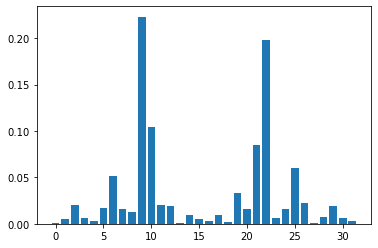

In [72]:
plot_bar_graph(x,y)

Given Graph with Edges:<br>
Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7), Edge(1, 3, 4), Edge(2, 3, 2), Edge(3, 4, 3)<br>
<br>
The optimal solution to Maxcut for the given Graph can be obtained by dividing the nodes in two groups using bits 0 and 1 as:<br>
0 1 2 3 4 <- nodes<br>
0 1 0 0 1 <- bitstring i.e |9><br><br>
    OR<br><br>
0 1 2 3 4 <- nodes<br>
1 0 1 1 0 <- bitstring i.e |22><br>
<br>
The plot has highest probabilities for the state |22> and |9>, exactly the result that was expected

### Results for simpler cases:
Graph with three edges

#### Initializing the circuit

In [73]:
# Defines the list of qubits

num = 3
depth = 4
rep = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]


# Defines the initialization

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

#### Case 1:

{('0', '1'): Text(0.2807096375319439, -0.5, '5'),
 ('0', '2'): Text(0.15777722737670685, 0.0970450977086984, '1'),
 ('1', '2'): Text(-0.4384868649086512, 0.4029549022913016, '7')}

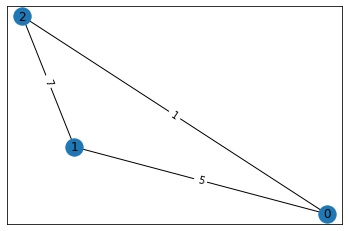

In [74]:
set_edges = [Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.edge_weight)


pos=nx.spring_layout(G) 
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [75]:
x, y = optimize()

(0, 0): ───H───ZZ──────────ZZ──────────X^0.095──────────────ZZ──────────ZZ─────────X^0.936───────────────ZZ──────────ZZ───────────X^0.869───────────────ZZ──────────ZZ─────────X^0.347──────────────M('x')───
               │           │                                │           │                                │           │                                  │           │                               │
(0, 1): ───H───ZZ^-0.753───┼───────────ZZ─────────X^0.095───ZZ^-0.005───┼──────────ZZ──────────X^0.936───ZZ^(8/13)───┼────────────ZZ──────────X^0.869───ZZ^-0.849───┼──────────ZZ─────────X^0.347───M────────
                           │           │                                │          │                                 │            │                                 │          │                    │
(0, 2): ───H───────────────ZZ^-0.551───ZZ^0.145───X^0.095───────────────ZZ^0.799───ZZ^-0.407───X^0.936───────────────ZZ^(12/13)───ZZ^(6/13)───X^0.869───────────────ZZ^-0.57───ZZ^0.012───X^0.34

Cost: -8.858
(0, 0): ───H───ZZ──────────ZZ──────────X^(-2/9)────────────────ZZ──────────ZZ─────────X^0.936───────────────ZZ──────────ZZ───────────X^0.869───────────────ZZ──────────ZZ─────────X^0.029──────────────M('x')───
               │           │                                   │           │                                │           │                                  │           │                               │
(0, 1): ───H───ZZ^-0.345───┼───────────ZZ───────────X^(-2/9)───ZZ^-0.005───┼──────────ZZ──────────X^0.936───ZZ^(8/13)───┼────────────ZZ──────────X^0.869───ZZ^-0.849───┼──────────ZZ─────────X^0.029───M────────
                           │           │                                   │          │                                 │            │                                 │          │                    │
(0, 2): ───H───────────────ZZ^-0.869───ZZ^(-1/12)───X^(-2/9)───────────────ZZ^0.799───ZZ^-0.407───X^0.936───────────────ZZ^(12/13)───ZZ^(6/13)───X^0.869───────────────

Cost: -7.476
(0, 0): ───H───ZZ──────────ZZ──────────X^(-2/9)────────────────ZZ──────────ZZ─────────X^0.936───────────────ZZ──────────ZZ───────────X^0.869───────────────ZZ──────────ZZ─────────X^0.344──────────────M('x')───
               │           │                                   │           │                                │           │                                  │           │                               │
(0, 1): ───H───ZZ^-0.345───┼───────────ZZ───────────X^(-2/9)───ZZ^-0.005───┼──────────ZZ──────────X^0.936───ZZ^(8/13)───┼────────────ZZ──────────X^0.869───ZZ^-0.651───┼──────────ZZ─────────X^0.344───M────────
                           │           │                                   │          │                                 │            │                                 │          │                    │
(0, 2): ───H───────────────ZZ^-0.869───ZZ^(-1/12)───X^(-2/9)───────────────ZZ^0.799───ZZ^-0.407───X^0.936───────────────ZZ^(12/13)───ZZ^(6/13)───X^0.869───────────────

Cost: -9.296
(0, 0): ───H───ZZ──────────ZZ──────────X^-0.221───────────────ZZ─────────ZZ─────────X^0.939───────────────ZZ─────────ZZ─────────X^0.882──────────────ZZ──────────ZZ───────────X^0.335───────────────M('x')───
               │           │                                  │          │                                │          │                               │           │                                  │
(0, 1): ───H───ZZ^-0.392───┼───────────ZZ──────────X^-0.221───ZZ^0.025───┼──────────ZZ──────────X^0.939───ZZ^0.719───┼──────────ZZ─────────X^0.882───ZZ^-0.913───┼────────────ZZ──────────X^0.335───M────────
                           │           │                                 │          │                                │          │                                │            │                     │
(0, 2): ───H───────────────ZZ^-0.878───ZZ^-0.149───X^-0.221──────────────ZZ^0.805───ZZ^-0.365───X^0.939──────────────ZZ^0.944───ZZ^0.606───X^0.882───────────────ZZ^(-7/12)───ZZ^-0

(0, 2): ───H───────────────ZZ^-0.88───ZZ^-0.162───X^-0.224───────────────ZZ^0.793───ZZ^-0.447───X^(15/16)──────────────ZZ^(14/15)───ZZ^0.531───X^(7/8)───────────────ZZ^-0.576───ZZ^-0.03───X^0.344───M────────
Cost: -9.768
(0, 0): ───H───ZZ──────────ZZ─────────X^(-2/9)───────────────ZZ──────────ZZ─────────X^(14/15)───────────────ZZ─────────ZZ───────────X^0.874──────────────ZZ──────────ZZ──────────X^0.341──────────────M('x')───
               │           │                                 │           │                                  │          │                                 │           │                                │
(0, 1): ───H───ZZ^-0.402───┼──────────ZZ──────────X^(-2/9)───ZZ^-0.033───┼──────────ZZ──────────X^(14/15)───ZZ^0.669───┼────────────ZZ─────────X^0.874───ZZ^-0.879───┼───────────ZZ─────────X^0.341───M────────
                           │          │                                  │          │                                  │            │                              

Cost: -9.846
(0, 0): ───H───ZZ──────────ZZ─────────X^(-2/9)───────────────ZZ──────────ZZ─────────X^(15/16)───────────────ZZ─────────ZZ─────────X^(7/8)──────────────ZZ─────────ZZ──────────X^0.344───────────────M('x')───
               │           │                                 │           │                                  │          │                               │          │                                 │
(0, 1): ───H───ZZ^-0.398───┼──────────ZZ──────────X^(-2/9)───ZZ^-0.034───┼──────────ZZ──────────X^(15/16)───ZZ^0.662───┼──────────ZZ─────────X^(7/8)───ZZ^-0.88───┼───────────ZZ──────────X^0.344───M────────
                           │          │                                  │          │                                  │          │                               │           │                     │
(0, 2): ───H───────────────ZZ^-0.88───ZZ^-0.158───X^(-2/9)───────────────ZZ^0.793───ZZ^-0.448───X^(15/16)──────────────ZZ^0.932───ZZ^0.527───X^(7/8)──────────────ZZ^-0.576───ZZ^-0

Cost: -9.816
(0, 0): ───H───ZZ────────ZZ─────────X^(-2/9)──────────────ZZ──────────ZZ─────────X^(15/16)───────────────ZZ─────────ZZ───────────X^(7/8)─────────────ZZ──────────ZZ──────────X^0.344───────────────M('x')───
               │         │                                │           │                                  │          │                                │           │                                 │
(0, 1): ───H───ZZ^-0.4───┼──────────ZZ─────────X^(-2/9)───ZZ^-0.033───┼──────────ZZ──────────X^(15/16)───ZZ^0.664───┼────────────ZZ────────X^(7/8)───ZZ^-0.879───┼───────────ZZ──────────X^0.344───M────────
                         │          │                                 │          │                                  │            │                               │           │                     │
(0, 2): ───H─────────────ZZ^-0.88───ZZ^-0.16───X^(-2/9)───────────────ZZ^0.793───ZZ^-0.446───X^(15/16)──────────────ZZ^(14/15)───ZZ^0.53───X^(7/8)───────────────ZZ^-0.576───ZZ^-0.031─

Cost: -9.884
(0, 0): ───H───ZZ────────ZZ─────────X^(-2/9)──────────────ZZ──────────ZZ─────────X^(15/16)───────────────ZZ─────────ZZ───────────X^(7/8)─────────────ZZ──────────ZZ──────────X^0.344───────────────M('x')───
               │         │                                │           │                                  │          │                                │           │                                 │
(0, 1): ───H───ZZ^-0.4───┼──────────ZZ─────────X^(-2/9)───ZZ^-0.033───┼──────────ZZ──────────X^(15/16)───ZZ^0.664───┼────────────ZZ────────X^(7/8)───ZZ^-0.879───┼───────────ZZ──────────X^0.344───M────────
                         │          │                                 │          │                                  │            │                               │           │                     │
(0, 2): ───H─────────────ZZ^-0.88───ZZ^-0.16───X^(-2/9)───────────────ZZ^0.793───ZZ^-0.447───X^(15/16)──────────────ZZ^(14/15)───ZZ^0.53───X^(7/8)───────────────ZZ^-0.576───ZZ^-0.031─

[0, 3, 6, 5, 4, 2, 1, 7]
[0.024, 0.093, 0.08, 0.311, 0.12, 0.289, 0.066, 0.017]


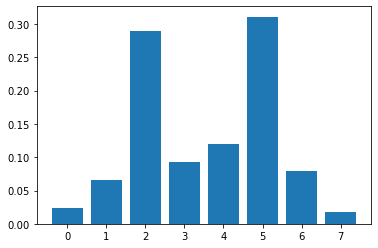

In [76]:
plot_bar_graph(x,y)

For case 1, the graph with Edges:
Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7)<br>
<br>
The nodes are divided in two groups using bits 0 and 1 to obtain the optimal Maxcut solution as:<br>
0 1 2 <- nodes<br>
0 1 0 <- bitstring i.e |2><br><br>
    OR<br><br>
0 1 2 <- nodes<br>
1 0 1 <- bitstring i.e |5><br>
<br>
The plot has highest probabilities for the state |5> and |2> which is exactly the expected result


#### Case 2:

{('0', '1'): Text(-0.5, -0.10793442109825432, '5'),
 ('0', '2'): Text(0.46038980931913065, 0.2706444339668675, '7'),
 ('1', '2'): Text(0.03961019068086935, -0.16271001286861383, '1')}

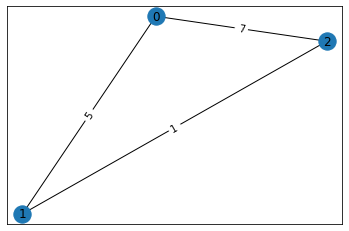

In [77]:
set_edges = [Edge(0, 1, 5), Edge(0, 2, 7), Edge(1, 2, 1)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.edge_weight)


pos=nx.spring_layout(G) 
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [78]:
x, y = optimize()

(0, 0): ───H───ZZ─────────ZZ──────────X^-0.146───────────────ZZ───────────ZZ──────────X^-0.512──────────────ZZ──────────ZZ─────────X^-0.296───────────────ZZ──────────ZZ──────────X^-0.019───────────────M('x')───
               │          │                                  │            │                                 │           │                                 │           │                                  │
(0, 1): ───H───ZZ^0.674───┼───────────ZZ──────────X^-0.146───ZZ^(11/14)───┼───────────ZZ─────────X^-0.512───ZZ^(-5/8)───┼──────────ZZ──────────X^-0.296───ZZ^-0.175───┼───────────ZZ──────────X^-0.019───M────────
                          │           │                                   │           │                                 │          │                                  │           │                      │
(0, 2): ───H──────────────ZZ^-0.657───ZZ^-0.665───X^-0.146────────────────ZZ^-0.101───ZZ^0.557───X^-0.512───────────────ZZ^0.324───ZZ^-0.525───X^-0.296───────────────ZZ^-0.

(0, 2): ───H───────────────ZZ^-0.885───ZZ^-0.984───X^-0.146───────────────ZZ^-0.329───ZZ^0.239───X^-0.831───────────────ZZ^0.324───ZZ^-0.525───X^-0.296──────────────ZZ^-0.473───ZZ^-0.353───X^-0.337───M────────
Cost: -4.396
(0, 0): ───H───ZZ─────────ZZ──────────X^-0.14──────────────ZZ─────────ZZ───────────X^-0.855───────────────ZZ──────────ZZ──────────X^-0.173───────────────ZZ─────────ZZ──────────X^0.237───────────────M('x')───
               │          │                                │          │                                   │           │                                  │          │                                 │
(0, 1): ───H───ZZ^0.675───┼───────────ZZ─────────X^-0.14───ZZ^0.908───┼────────────ZZ──────────X^-0.855───ZZ^-0.119───┼───────────ZZ──────────X^-0.173───ZZ^0.218───┼───────────ZZ──────────X^0.237───M────────
                          │           │                               │            │                                  │           │                              

Cost: -10.874
(0, 0): ───H───ZZ────────────ZZ──────────X^(-1/15)───────────────ZZ──────────ZZ──────────X^-0.832──────────────ZZ──────────ZZ────────X^-0.299───────────────ZZ─────────ZZ──────────X^-0.099───────────────M('x')───
               │             │                                   │           │                                 │           │                                │          │                                  │
(0, 1): ───H───ZZ^(-14/15)───┼───────────ZZ──────────X^(-1/15)───ZZ^-0.796───┼───────────ZZ─────────X^-0.832───ZZ^-0.621───┼─────────ZZ──────────X^-0.299───ZZ^0.035───┼───────────ZZ──────────X^-0.099───M────────
                             │           │                                   │           │                                 │         │                                 │           │                      │
(0, 2): ───H─────────────────ZZ^-0.907───ZZ^-0.987───X^(-1/15)───────────────ZZ^-0.314───ZZ^0.241───X^-0.832───────────────ZZ^0.33───ZZ^-0.524───X^-0.299─

Cost: -10.896
(0, 0): ───H───ZZ──────────ZZ───────────X^-0.07───────────────ZZ──────────ZZ──────────X^-0.851──────────────ZZ──────────ZZ─────────X^-0.296──────────────ZZ─────────ZZ──────────X^-0.018───────────────M('x')───
               │           │                                  │           │                                 │           │                                │          │                                  │
(0, 1): ───H───ZZ^-0.725───┼────────────ZZ──────────X^-0.07───ZZ^-0.803───┼───────────ZZ─────────X^-0.851───ZZ^-0.599───┼──────────ZZ─────────X^-0.296───ZZ^0.029───┼───────────ZZ──────────X^-0.018───M────────
                           │            │                                 │           │                                 │          │                                │           │                      │
(0, 2): ───H───────────────ZZ^(-8/13)───ZZ^-0.945───X^-0.07───────────────ZZ^-0.325───ZZ^0.239───X^-0.851───────────────ZZ^0.361───ZZ^-0.52───X^-0.296──────────────ZZ

Cost: -10.42
(0, 0): ───H───ZZ────────────ZZ──────────X^(-1/16)───────────────ZZ──────────ZZ─────────X^(-6/7)──────────────ZZ──────────ZZ──────────X^-0.297───────────────ZZ─────────ZZ─────────X^-0.023───────────────M('x')───
               │             │                                   │           │                                │           │                                  │          │                                 │
(0, 1): ───H───ZZ^(-12/13)───┼───────────ZZ──────────X^(-1/16)───ZZ^-0.779───┼──────────ZZ─────────X^(-6/7)───ZZ^-0.635───┼───────────ZZ──────────X^-0.297───ZZ^0.014───┼──────────ZZ──────────X^-0.023───M────────
                             │           │                                   │          │                                 │           │                                 │          │                      │
(0, 2): ───H─────────────────ZZ^-0.893───ZZ^-0.985───X^(-1/16)───────────────ZZ^-0.29───ZZ^0.244───X^(-6/7)───────────────ZZ^(5/16)───ZZ^-0.527───X^-0.297─

(0, 2): ───H──────────────ZZ^(-8/9)───ZZ^-0.984───X^(-1/15)───────────────ZZ^-0.287───ZZ^0.245───X^-0.853───────────────ZZ^0.299───ZZ^-0.529───X^-0.297───────────────ZZ^-0.838───ZZ^-0.405───X^-0.017───M────────
Cost: -10.8
(0, 0): ───H───ZZ──────────ZZ──────────X^(-1/15)───────────────ZZ──────────ZZ───────────X^-0.852──────────────ZZ──────────ZZ─────────X^-0.298───────────────ZZ─────────ZZ──────────X^-0.021───────────────M('x')───
               │           │                                   │           │                                  │           │                                 │          │                                  │
(0, 1): ───H───ZZ^-0.908───┼───────────ZZ──────────X^(-1/15)───ZZ^-0.766───┼────────────ZZ─────────X^-0.852───ZZ^-0.647───┼──────────ZZ──────────X^-0.298───ZZ^-0.02───┼───────────ZZ──────────X^-0.021───M────────
                           │           │                                   │            │                                 │          │               

(0, 2): ───H──────────────ZZ^(-8/9)───ZZ^-0.984───X^(-1/15)───────────────ZZ^(-3/11)───ZZ^0.247───X^-0.852───────────────ZZ^0.278───ZZ^-0.532───X^-0.297───────────────ZZ^-0.821───ZZ^-0.403───X^-0.019───M────────
Cost: -10.802
(0, 0): ───H───ZZ──────────ZZ──────────X^(-1/15)───────────────ZZ──────────ZZ──────────X^-0.851──────────────ZZ──────────ZZ─────────X^-0.298───────────────ZZ──────────ZZ──────────X^-0.019───────────────M('x')───
               │           │                                   │           │                                 │           │                                 │           │                                  │
(0, 1): ───H───ZZ^-0.926───┼───────────ZZ──────────X^(-1/15)───ZZ^-0.773───┼───────────ZZ─────────X^-0.851───ZZ^-0.654───┼──────────ZZ──────────X^-0.298───ZZ^-0.015───┼───────────ZZ──────────X^-0.019───M────────
                           │           │                                   │           │                                 │          │             

(0, 2): ───H───────────────ZZ^-0.887───ZZ^-0.984───X^(-1/15)───────────────ZZ^(-3/11)───ZZ^0.247───X^-0.852───────────────ZZ^0.279───ZZ^-0.532───X^-0.297───────────────ZZ^-0.816───ZZ^-0.402───X^-0.02───M────────
Cost: -10.802
(0, 0): ───H───ZZ──────────ZZ──────────X^(-1/15)───────────────ZZ──────────ZZ───────────X^-0.851──────────────ZZ──────────ZZ─────────X^-0.297───────────────ZZ──────────ZZ──────────X^-0.02───────────────M('x')───
               │           │                                   │           │                                  │           │                                 │           │                                 │
(0, 1): ───H───ZZ^-0.919───┼───────────ZZ──────────X^(-1/15)───ZZ^-0.766───┼────────────ZZ─────────X^-0.851───ZZ^-0.658───┼──────────ZZ──────────X^-0.297───ZZ^-0.012───┼───────────ZZ──────────X^-0.02───M────────
                           │           │                                   │            │                                 │          │            

Cost: -10.744
(0, 0): ───H───ZZ─────────ZZ──────────X^(-1/15)───────────────ZZ──────────ZZ───────────X^-0.851──────────────ZZ──────────ZZ─────────X^-0.297───────────────ZZ──────────ZZ──────────X^-0.02───────────────M('x')───
               │          │                                   │           │                                  │           │                                 │           │                                 │
(0, 1): ───H───ZZ^-0.92───┼───────────ZZ──────────X^(-1/15)───ZZ^-0.766───┼────────────ZZ─────────X^-0.851───ZZ^-0.658───┼──────────ZZ──────────X^-0.297───ZZ^-0.012───┼───────────ZZ──────────X^-0.02───M────────
                          │           │                                   │            │                                 │          │                                  │           │                     │
(0, 2): ───H──────────────ZZ^-0.887───ZZ^-0.984───X^(-1/15)───────────────ZZ^(-3/11)───ZZ^0.247───X^-0.851───────────────ZZ^0.279───ZZ^-0.532───X^-0.297──────

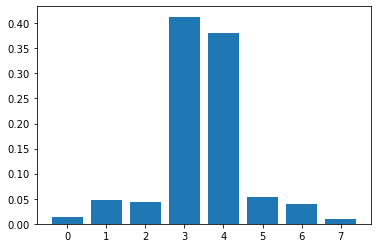

In [79]:
plot_bar_graph(x,y)

For case 2, the graph with Edges:
Edge(0, 1, 5), Edge(0, 2, 7), Edge(1, 2, 1)<br>
<br>
To obtain the optimal solution, the nodes should be seperated in two groups as follows:<br>
0 1 2 <- nodes<br>
0 1 1 <- bitstring i.e |3><br><br>
    OR<br><br>
0 1 2 <- nodes<br>
1 0 0 <- bitstring i.e |4><br>
<br>
The plot has highest probabilities for the expected result state |3> and |4>.<br>

### Case for which the output result does not match with expected optimal solution:

In [80]:
# Defines the list of qubits

num = 5
depth = 4
rep = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]


# Defines the initialization

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

{('0', '1'): Text(-0.01866757271434632, 0.6174141572500332, '5'),
 ('0', '2'): Text(-0.12964254413154547, 0.4645873771712396, '1'),
 ('1', '2'): Text(-0.08607098413865243, 0.20553777606710674, '7'),
 ('1', '3'): Text(0.026722115340791896, 0.035412622828760454, '4'),
 ('2', '3'): Text(-0.08425285607640726, -0.11741415725003315, '10'),
 ('3', '4'): Text(0.11719055049227173, -0.6437696552441897, '3')}

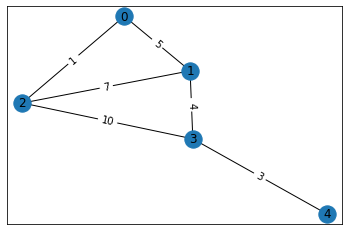

In [81]:
set_edges = [Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7), Edge(1, 3, 4), Edge(2, 3, 10), Edge(3, 4, 3)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.edge_weight)


pos=nx.spring_layout(G) 
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [82]:
x, y = optimize()

(0, 0): ───H───ZZ─────────ZZ─────────X^-0.21─────────────────────────────ZZ──────────ZZ──────────X^-0.43───────────────────────────ZZ──────────ZZ──────────X^-0.43────────────────────────────ZZ──────────ZZ───────────X^0.885─────────────────────────────────────────────────M('x')───
               │          │                                              │           │                                             │           │                                              │           │                                                                    │
(0, 1): ───H───ZZ^0.292───┼──────────ZZ──────────ZZ──────────X^-0.21─────ZZ^-0.982───┼───────────ZZ──────────ZZ─────────X^-0.43────ZZ^0.69─────┼───────────ZZ──────────ZZ─────────X^-0.43─────ZZ^0.44─────┼────────────ZZ──────────ZZ─────────X^0.885──────────────────────────M────────
                          │          │           │                                   │           │           │                                 │           │         

Cost: -18.674
(0, 0): ───H───ZZ─────────ZZ─────────X^-0.21─────────────────────────────ZZ──────────ZZ──────────X^-0.748──────────────────────────ZZ──────────ZZ─────────X^-0.43───────────────────────────ZZ─────────ZZ───────────X^0.885─────────────────────────────────────────────────M('x')───
               │          │                                              │           │                                             │           │                                            │          │                                                                    │
(0, 1): ───H───ZZ^0.292───┼──────────ZZ──────────ZZ──────────X^-0.21─────ZZ^-0.982───┼───────────ZZ──────────ZZ─────────X^-0.748───ZZ^-0.902───┼──────────ZZ──────────ZZ─────────X^-0.43────ZZ^0.44────┼────────────ZZ──────────ZZ─────────X^0.885──────────────────────────M────────
                          │          │           │                                   │           │           │                                 │          │     

Cost: -17.967
(0, 0): ───H───ZZ─────────ZZ──────────X^-0.35────────────────────────────ZZ───────────ZZ──────────X^-0.752─────────────────────────ZZ──────────ZZ─────────X^-0.389────────────────────────────ZZ─────────ZZ──────────X^0.927─────────────────────────────────────────────────M('x')───
               │          │                                              │            │                                            │           │                                              │          │                                                                   │
(0, 1): ───H───ZZ^0.306───┼───────────ZZ──────────ZZ──────────X^-0.35────ZZ^-0.762────┼───────────ZZ──────────ZZ────────X^-0.752───ZZ^0.767────┼──────────ZZ──────────ZZ──────────X^-0.389────ZZ^0.479───┼───────────ZZ──────────ZZ─────────X^0.927──────────────────────────M────────
                          │           │           │                                   │           │           │                                │          │  

Cost: -18.435
(0, 0): ───H───ZZ─────────ZZ─────────X^-0.201────────────────────────────ZZ──────────ZZ──────────X^-0.74───────────────────────────ZZ────────────ZZ─────────X^-0.486──────────────────────────ZZ──────────ZZ──────────X^0.89───────────────────────────────────────────────────M('x')───
               │          │                                              │           │                                             │             │                                            │           │                                                                    │
(0, 1): ───H───ZZ^0.212───┼──────────ZZ──────────ZZ───────────X^-0.201───ZZ^-0.882───┼───────────ZZ──────────ZZ─────────X^-0.74────ZZ^0.931──────┼──────────ZZ─────────ZZ─────────X^-0.486────ZZ^(4/9)────┼───────────ZZ──────────ZZ─────────X^0.89────────────────────────────M────────
                          │          │           │                                   │           │           │                                   │     

Cost: -11.243
(0, 0): ───H───ZZ─────────ZZ─────────X^-0.244───────────────────────────ZZ──────────ZZ──────────X^-0.749───────────────────────────ZZ──────────ZZ─────────X^-0.421────────────────────────────ZZ──────────ZZ──────────X^0.896───────────────────────────────────────────────────M('x')───
               │          │                                             │           │                                              │           │                                              │           │                                                                     │
(0, 1): ───H───ZZ^0.287───┼──────────ZZ──────────ZZ──────────X^-0.244───ZZ^-0.912───┼───────────ZZ──────────ZZ──────────X^-0.749───ZZ^0.719────┼──────────ZZ──────────ZZ─────────X^-0.421─────ZZ^(4/9)────┼───────────ZZ──────────ZZ─────────X^0.896────────────────────────────M────────
                          │          │           │                                  │           │           │                                  │    

Cost: -18.545
(0, 0): ───H───ZZ─────────ZZ─────────X^-0.209────────────────────────────ZZ──────────ZZ──────────X^-0.748──────────────────────────ZZ──────────ZZ──────────X^-0.43────────────────────────────ZZ──────────ZZ──────────X^0.884─────────────────────────────────────────────────M('x')───
               │          │                                              │           │                                             │           │                                              │           │                                                                   │
(0, 1): ───H───ZZ^0.292───┼──────────ZZ──────────ZZ──────────X^-0.209────ZZ^-0.979───┼───────────ZZ──────────ZZ─────────X^-0.748───ZZ^0.689────┼───────────ZZ──────────ZZ─────────X^-0.43─────ZZ^0.49─────┼───────────ZZ──────────ZZ─────────X^0.884──────────────────────────M────────
                          │          │           │                                   │           │           │                                 │          

Cost: -18.737
(0, 0): ───H───ZZ─────────ZZ─────────X^-0.21───────────────────────────ZZ──────────ZZ────────X^-0.749───────────────────────────ZZ─────────ZZ─────────X^(-3/7)───────────────────────────ZZ──────────ZZ───────────X^0.887──────────────────────────────────────────────────M('x')───
               │          │                                            │           │                                            │          │                                             │           │                                                                     │
(0, 1): ───H───ZZ^0.293───┼──────────ZZ─────────ZZ──────────X^-0.21────ZZ^0.999────┼─────────ZZ─────────ZZ──────────X^-0.749────ZZ^0.702───┼──────────ZZ──────────ZZ─────────X^(-3/7)────ZZ^0.442────┼────────────ZZ───────────ZZ─────────X^0.887──────────────────────────M────────
                          │          │          │                                  │         │          │                                  │          │           │

Cost: -18.475
(0, 0): ───H───ZZ─────────ZZ─────────X^-0.213───────────────────────────ZZ──────────ZZ─────────X^-0.749─────────────────────ZZ──────────ZZ──────────X^-0.431──────────────────────────────ZZ───────────ZZ───────────X^0.89──────────────────────────────────────────────────M('x')───
               │          │                                             │           │                                       │           │                                                 │            │                                                                    │
(0, 1): ───H───ZZ^0.289───┼──────────ZZ──────────ZZ──────────X^-0.213───ZZ──────────┼──────────ZZ─────────ZZ─────X^-0.749───ZZ^(9/13)───┼───────────ZZ───────────ZZ──────────X^-0.431─────ZZ^0.442─────┼────────────ZZ───────────ZZ─────────X^0.89──────────────────────────M────────
                          │          │           │                                  │          │          │                             │           │           

(0, 4): ───H─────────────────────────────────────────────────────────────ZZ^(-8/13)───X^-0.209──────────────────────────────────────ZZ^-0.996───X^-0.752─────────────────────────────────────ZZ^-0.38───X^(-3/7)──────────────────────────────────────ZZ^-0.932───X^(8/9)───M────────
Cost: -18.324
(0, 0): ───H───ZZ─────────ZZ──────────X^-0.209───────────────────────────ZZ──────────ZZ──────────X^-0.749──────────────────────────ZZ──────────ZZ─────────X^-0.427───────────────────────────ZZ──────────ZZ─────────X^(8/9)───────────────────────────────────────────────────M('x')───
               │          │                                              │           │                                             │           │                                             │           │                                                                    │
(0, 1): ───H───ZZ^0.311───┼───────────ZZ──────────ZZ──────────X^-0.209───ZZ^-0.996───┼───────────ZZ──────────ZZ─────────X^-0.749───ZZ^0.701────┼──────────ZZ

Cost: -18.519
(0, 0): ───H───ZZ──────────ZZ──────────X^-0.209──────────────────────────────ZZ───────────ZZ─────────X^-0.751───────────────────────────ZZ─────────ZZ─────────X^-0.427────────────────────────ZZ─────────ZZ─────────X^0.887─────────────────────────────────────────────────M('x')───
               │           │                                                 │            │                                             │          │                                          │          │                                                                  │
(0, 1): ───H───ZZ^(4/13)───┼───────────ZZ────────────ZZ───────────X^-0.209───ZZ^0.999─────┼──────────ZZ─────────ZZ──────────X^-0.751────ZZ^0.7─────┼──────────ZZ─────────ZZ────────X^-0.427───ZZ^0.449───┼──────────ZZ──────────ZZ─────────X^0.887──────────────────────────M────────
                           │           │             │                                    │          │          │                                  │          │ 

Cost: -18.292
(0, 0): ───H───ZZ──────────ZZ──────────X^-0.209──────────────────────────────ZZ───────────ZZ──────────X^-0.75───────────────────────────ZZ──────────ZZ────────X^-0.427───────────────────────────ZZ──────────ZZ─────────X^(8/9)─────────────────────────────────────────────────M('x')───
               │           │                                                 │            │                                             │           │                                            │           │                                                                  │
(0, 1): ───H───ZZ^(4/13)───┼───────────ZZ────────────ZZ───────────X^-0.209───ZZ^-0.996────┼───────────ZZ──────────ZZ─────────X^-0.75────ZZ^0.701────┼─────────ZZ──────────ZZ─────────X^-0.427────ZZ^0.449────┼──────────ZZ──────────ZZ─────────X^(8/9)──────────────────────────M────────
                           │           │             │                                    │           │           │                                 

Cost: -18.364
(0, 0): ───H───ZZ─────────ZZ──────────X^-0.209───────────────────────────ZZ───────────ZZ──────────X^-0.751──────────────────────────ZZ──────────ZZ─────────X^-0.427───────────────────────────ZZ──────────ZZ─────────X^(8/9)─────────────────────────────────────────────────M('x')───
               │          │                                              │            │                                             │           │                                             │           │                                                                  │
(0, 1): ───H───ZZ^0.306───┼───────────ZZ──────────ZZ──────────X^-0.209───ZZ^-0.996────┼───────────ZZ──────────ZZ─────────X^-0.751───ZZ^0.703────┼──────────ZZ──────────ZZ─────────X^-0.427────ZZ^0.448────┼──────────ZZ──────────ZZ─────────X^(8/9)──────────────────────────M────────
                          │           │           │                                   │           │           │                                 │          │ 

Cost: -18.565
(0, 0): ───H───ZZ─────────ZZ──────────X^-0.209───────────────────────────ZZ───────────ZZ──────────X^-0.751──────────────────────────ZZ──────────ZZ─────────X^-0.427───────────────────────────ZZ──────────ZZ─────────X^(8/9)─────────────────────────────────────────────────M('x')───
               │          │                                              │            │                                             │           │                                             │           │                                                                  │
(0, 1): ───H───ZZ^0.306───┼───────────ZZ──────────ZZ──────────X^-0.209───ZZ^-0.996────┼───────────ZZ──────────ZZ─────────X^-0.751───ZZ^0.703────┼──────────ZZ──────────ZZ─────────X^-0.427────ZZ^0.448────┼──────────ZZ──────────ZZ─────────X^(8/9)──────────────────────────M────────
                          │           │           │                                   │           │           │                                 │          │ 

(0, 4): ───H─────────────────────────────────────────────────────────────ZZ^(-8/13)───X^-0.209──────────────────────────────────────ZZ^-0.998───X^-0.751──────────────────────────────────────ZZ^-0.378───X^-0.427──────────────────────────────────────ZZ^-0.932───X^(8/9)───M────────
Cost: -18.481
(0, 0): ───H───ZZ─────────ZZ──────────X^-0.209───────────────────────────ZZ───────────ZZ──────────X^-0.751──────────────────────────ZZ──────────ZZ─────────X^-0.427───────────────────────────ZZ──────────ZZ──────────X^(8/9)─────────────────────────────────────────────────M('x')───
               │          │                                              │            │                                             │           │                                             │           │                                                                   │
(0, 1): ───H───ZZ^0.306───┼───────────ZZ──────────ZZ──────────X^-0.209───ZZ^-0.997────┼───────────ZZ──────────ZZ─────────X^-0.751───ZZ^0.703────┼─────────

Cost: -18.574
(0, 0): ───H───ZZ─────────ZZ──────────X^-0.209───────────────────────────ZZ───────────ZZ──────────X^-0.751──────────────────────────ZZ──────────ZZ─────────X^-0.427───────────────────────────ZZ──────────ZZ──────────X^(8/9)─────────────────────────────────────────────────M('x')───
               │          │                                              │            │                                             │           │                                             │           │                                                                   │
(0, 1): ───H───ZZ^0.306───┼───────────ZZ──────────ZZ──────────X^-0.209───ZZ^-0.997────┼───────────ZZ──────────ZZ─────────X^-0.751───ZZ^0.703────┼──────────ZZ──────────ZZ─────────X^-0.427────ZZ^0.447────┼───────────ZZ──────────ZZ─────────X^(8/9)──────────────────────────M────────
                          │           │           │                                   │           │           │                                 │         

Cost: -18.708
(0, 0): ───H───ZZ─────────ZZ──────────X^-0.209───────────────────────────ZZ───────────ZZ──────────X^-0.751──────────────────────────ZZ──────────ZZ─────────X^-0.427───────────────────────────ZZ──────────ZZ──────────X^(8/9)─────────────────────────────────────────────────M('x')───
               │          │                                              │            │                                             │           │                                             │           │                                                                   │
(0, 1): ───H───ZZ^0.306───┼───────────ZZ──────────ZZ──────────X^-0.209───ZZ^-0.997────┼───────────ZZ──────────ZZ─────────X^-0.751───ZZ^0.703────┼──────────ZZ──────────ZZ─────────X^-0.427────ZZ^0.447────┼───────────ZZ──────────ZZ─────────X^(8/9)──────────────────────────M────────
                          │           │           │                                   │           │           │                                 │         

Cost: -18.737
(0, 0): ───H───ZZ─────────ZZ──────────X^-0.209───────────────────────────ZZ───────────ZZ──────────X^-0.751──────────────────────────ZZ──────────ZZ─────────X^-0.427───────────────────────────ZZ──────────ZZ──────────X^(8/9)─────────────────────────────────────────────────M('x')───
               │          │                                              │            │                                             │           │                                             │           │                                                                   │
(0, 1): ───H───ZZ^0.306───┼───────────ZZ──────────ZZ──────────X^-0.209───ZZ^-0.997────┼───────────ZZ──────────ZZ─────────X^-0.751───ZZ^0.703────┼──────────ZZ──────────ZZ─────────X^-0.427────ZZ^0.447────┼───────────ZZ──────────ZZ─────────X^(8/9)──────────────────────────M────────
                          │           │           │                                   │           │           │                                 │         

Cost: -18.594
     fun: -18.594
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 88
  status: 1
 success: True
       x: array([-1.44891796,  0.65714959,  3.13945796,  2.35836065, -1.69814219,
        1.34113273,  0.97561142, -2.78976674])
(0, 0): ───H───ZZ─────────ZZ──────────X^-0.209───────────────────────────ZZ───────────ZZ──────────X^-0.751──────────────────────────ZZ──────────ZZ─────────X^-0.427───────────────────────────ZZ──────────ZZ──────────X^(8/9)─────────────────────────────────────────────────M('x')───
               │          │                                              │            │                                             │           │                                             │           │                                                                   │
(0, 1): ───H───ZZ^0.306───┼───────────ZZ──────────ZZ──────────X^-0.209───ZZ^-0.997────┼───────────ZZ──────────ZZ─────────X^-0.751───ZZ^0.703────┼──────────ZZ──────────ZZ─────────X^-0.

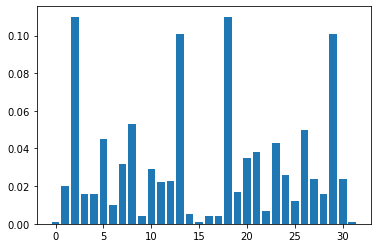

In [83]:
plot_bar_graph(x,y)

Expected optimal solution for this case is |21> and |10> but the plot results are not as expected

### Conclusion:
1. QAOA has the potential to solve combinatorial optimization problems.
2. If the optimization function get stuck in some local minimum, we get an unexpected plot.
3. Nodes are seperated in alternate fashion so the perfect solution may not be possible for complex graphs. 